In [1]:
with open("mod_hyde/data/all_book_data.txt","r") as f:
    all_books_data = f.read() 

In [2]:
import json

youtube_transcripts_list = ["chunked_misc_transcripts.json","chunked_transcripts_undergrad.json","chunked_transcripts_mba.json"]    
all_youtube_data = []
for file in youtube_transcripts_list:
    with open('mod_hyde/data/YouTube_API_Transcripts/'+file) as f:
        data = json.load(f)
    for id,data in data.items():
        for d in data:
            all_youtube_data.append(d['text'])

In [3]:
import re

all_books_data_list = re.split(r"(?<=[.?!])\s+", all_books_data)

## CHUNKING 

In [2]:
!pip install -Uqq langchain

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    separators = [". "],
    chunk_size=1750,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,

)

books_data_splitted_text = text_splitter.split_text(all_books_data)

In [5]:
all_data = books_data_splitted_text + all_youtube_data

## DISTILBERT

In [7]:
from transformers import AutoTokenizer

import pandas as pd

df = pd.DataFrame(all_data,columns=["text"])

def tokenize_function(examples):
    return tokenizer(examples["text"])

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
from datasets import Dataset
import pandas as pd

hf_dataset = Dataset.from_pandas(df)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

/home/athekunal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Map (num_proc=4): 100%|██████████| 8394/8394 [00:03<00:00, 2659.38 examples/s]


In [8]:
block_size = 1024
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)


Map (num_proc=4): 100%|██████████| 8394/8394 [00:10<00:00, 808.40 examples/s] 


In [18]:
# lm_datasets[0]['input_ids']

In [17]:
lm_datasets[0]['labels'] == lm_datasets[0]['input_ids']

True

In [6]:
# from transformers import AutoTokenizer, AutoModelForCausalLM

# model_name = "distilbert/distilgpt2"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name)

In [21]:
all_books_data_list[1]

'These stories not only sound persuasive and reasonable but are also backed up by evidence - anecdotal, in some cases, and statistical, in others - that the strategies work.'

In [8]:
import pandas as pd

wiki_df = pd.read_csv("mod_hyde/data/wikipedia_data.csv")

In [9]:
wiki_df['len_count'] = wiki_df.apply(lambda row: len(str(row.text).split(" ")),axis=1)

In [10]:
def gte_100_words(row):
    if row['len_count'] >= 100:
        return True
    else:
        return False

wiki_df = wiki_df[wiki_df.apply(gte_100_words,axis=1)]
len(wiki_df)

31708

In [1]:
from datasets import load_dataset
hotpot_qa = load_dataset("hotpot_qa","distractor")

/home/athekunal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
shuffled_dataset = hotpot_qa['train'].shuffle(42)
subset_data = shuffled_dataset[0:5000]

In [3]:
val_subset = subset_data['supporting_facts']
titles = []
for sd in val_subset:
    titles.append(sd['title'])

In [4]:
val_questions = subset_data['question']

In [11]:
val_wiki_list = list(wiki_df['title'].values)
question_not_there = []
question_ther = []
for idx,title in enumerate(titles):
    for t in title:
        if t not in val_wiki_list:
            question_not_there.append(idx)
            continue

In [12]:
len(val_questions) - len(question_not_there)

2662

In [13]:
len(question_not_there)

2338

In [22]:
question_there_idx = [id for id in range(len(val_questions)) if id not in question_not_there]

In [24]:
final_df = pd.DataFrame(columns=['title','text'])
all_titles = []
all_texts = []
wikipedia_questions = []
for t in question_there_idx[:1000]:
    wikipedia_questions.append(val_questions[t])
    # for wikipedia_titles in t:
    #     all_titles.append(wikipedia_titles)
    #     all_texts.append(wiki_df[wiki_df['title'] == wikipedia_titles]['text'].values[0])

# final_df['title'] = all_titles
# final_df['text'] = all_texts

In [26]:
with open('wikipedia_qs.txt', 'w') as f:
    for line in wikipedia_questions:
        f.write(f"{line}\n")

In [15]:
final_df.drop_duplicates(subset=['title'],inplace=True)

len(final_df)

1977

In [17]:
final_df.to_csv('Filtered_wikipedia.csv',index=False)

In [6]:
import pandas as pd

final_df = pd.read_csv('Filtered_wikipedia.csv')

In [7]:
final_df.head()

,title,text
0,Sacramento International Airport,Sacramento International Airport (SMF) opened ...
1,Knox County Regional Airport,The airport was built during World War II and ...
2,Peter Hobbs (engineer),"Peter Hobbs was born in Langton, Tunbridge Wel..."
3,Russell Hobbs,After serving with the British Army's REME in ...
4,Gabriela Mistral,"Mistral was born in Vicuña, Chile, but grew up..."


In [19]:
import nltk
from nltk.corpus import words

# Download the NLTK words corpus
nltk.download('words')

# Set of English words from NLTK corpus
english_words = set(words.words())

[nltk_data] Downloading package words to /home/athekunal/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [54]:
import re

train_data_wikipedia_text = list(final_df['text'].values)
def preprocess_wikipedia_text(line:str):
    line = re.sub('==REFERENCES==', '', line)
    line = re.sub('== References ==', '', line)
    line = re.sub('== Notes ==', '', line)
    line = re.sub('== Notes and references ==', '', line)
    line = re.sub(r'ISBN.*', '', line)
    line = re.sub(r'(https?:\S+?)/.*', '', line)
    words_list = nltk.word_tokenize(line)
    english_words_list = [word for word in words_list if word.lower() in english_words]
    english_text = ' '.join(english_words_list)
    return english_text
# with open("mod_hyde/data/wikipedia_filtered.txt",'w') as f:
#     for line in train_data_wikipedia_text:
#         english_text = preprocess_wikipedia_text(line)        
        
#         f.writelines(english_text)
    # f.write("-"*100)

for text in train_data_wikipedia_text:
    english_text = preprocess_wikipedia_text(text)
    with open("mod_hyde/data/wikipedia_filtered_english.txt",'a') as f:
        f.writelines(english_text)
        f.write("\n-----------\n")

In [44]:
len(train_data_wikipedia_text)

1977

In [47]:
with open("mod_hyde/data/wikipedia_filtered.txt","r") as f:
    wikipedia_data = f.read()

In [50]:
print(len(wikipedia_data.split("-----------")))

1978


In [27]:
print(preprocess_wikipedia_text(train_data_wikipedia_text[0]))

Sacramento International Airport (SMF) opened on October 21, 1967, as Sacramento Metropolitan Airport (the airfield itself was Sacramento Metropolitan Field), with one 8600-foot runway. The initial runway was on the west side of the airfield and is now named to the headings of 17R/35L. Previously, air service to Sacramento was handled by Sacramento Municipal Airport (SAC), now known as Sacramento Executive Airport. Sacramento Metropolitan was the first purpose-built public-use airport west of the Mississippi when it opened in 1967. All airports under the Sacramento County Airport System (previously the Sacramento County Department of Airports), including SMF, are self-supporting through user fees and rentals. No local, state or federal tax funds are used for operating costs.
The airport initially had five airlines: Pacific Air Lines, Pacific Southwest Airlines (PSA), United Airlines, Western Airlines and West Coast Airlines.
September 11 did not deter growth at Sacramento International

In [29]:
print(train_data_wikipedia_text[0])

Sacramento International Airport (SMF) opened on October 21, 1967, as Sacramento Metropolitan Airport (the airfield itself was Sacramento Metropolitan Field), with one 8600-foot runway. The initial runway was on the west side of the airfield and is now named to the headings of 17R/35L. Previously, air service to Sacramento was handled by Sacramento Municipal Airport (SAC), now known as Sacramento Executive Airport. Sacramento Metropolitan was the first purpose-built public-use airport west of the Mississippi when it opened in 1967. All airports under the Sacramento County Airport System (previously the Sacramento County Department of Airports), including SMF, are self-supporting through user fees and rentals. No local, state or federal tax funds are used for operating costs.
The airport initially had five airlines: Pacific Air Lines, Pacific Southwest Airlines (PSA), United Airlines, Western Airlines and West Coast Airlines.
September 11 did not deter growth at Sacramento International

## PREPROCESSING
1. ==REFERENCES==
2. ISBN NUMBERS
3. REGEX FOR LINKS (https?:\S+?)/.*

In [8]:
final_df.columns

Index(['title', 'text'], dtype='object')

In [9]:
all_titles = list(final_df['title'].values)

In [10]:
import wikipediaapi
wikipedia_module = wikipediaapi.Wikipedia("HyDE-Project (athekunal@gmail.com)", "en")



In [18]:
idxs = 5
page_py = wikipedia_module.page(all_titles[idxs])
print(all_titles[idxs])
for i in page_py.sections:
    print(i.title,i.full_text)

G. K. Chesterton
Biography <bound method WikipediaPageSection.full_text of Section: Biography (1):

Subsections (3):
Section: Early life (2):
Chesterton was born in Campden Hill in Kensington, London, the son of Edward Chesterton (1841–1922), an estate agent, and Marie Louise, née Grosjean, of Swiss French origin. Chesterton was baptised at the age of one month into the Church of England, though his family themselves were irregularly practising Unitarians. According to his autobiography, as a young man he became fascinated with the occult and, along with his brother Cecil, experimented with Ouija boards. He was educated at St Paul's School, then attended the Slade School of Art to become an illustrator. The Slade is a department of University College London, where Chesterton also took classes in literature, but he did not complete a degree in either subject. He married Frances Blogg in 1901; the marriage lasted the rest of his life. Chesterton credited Frances with leading him back to 

In [25]:

not_there = 0
for title in titles:
    if title not in val_wiki_list:
        not_there += 1

In [27]:
len(titles)

18005

In [8]:
wiki_df['len_count'] = wiki_df.apply(lambda row: len(str(row.text).split(" ")),axis=1)

In [11]:
wiki_df['len_count'].value_counts(sort='asc')

len_count
1       6262
3        711
5        221
7        204
6        193
        ... 
2777       1
3325       1
3898       1
2346       1
2138       1
Name: count, Length: 3222, dtype: int64

In [12]:
wiki_df

,title,text,len_count
0,"Vinalhaven, Maine",Archeological remains indicate that the island...,996
1,"Owls Head, Maine",When Samuel de Champlain explored Owl's Head i...,347
2,"North Haven, Maine","As early as 3300 BCE, the island was visited b...",515
3,Downeast Flight 46,There was poor visibility around Rockland on t...,617
4,Northern California TRACON,Southern California TRACON\n\n\n== References ...,5
...,...,...,...
46306,Dance in California,\n\n\nCrockett-Deane Ballet\nDance Connection ...,40
46307,Miguel de la Madrid,Miguel de la Madrid was born in the city of Co...,1481
46308,Los Pinos,"After the Spanish Conquest, around 1550, a tra...",199
46309,Eugene Allen Gilmore,"Gilmore was born in Brownville, Nebraska to An...",156


In [13]:
def gte_100_words(row):
    if row['len_count'] >= 100:
        return True
    else:
        return False

wiki_df = wiki_df[wiki_df.apply(gte_100_words,axis=1)]

In [14]:
len(wiki_df)

31708

In [15]:
wiki_df

,title,text,len_count
0,"Vinalhaven, Maine",Archeological remains indicate that the island...,996
1,"Owls Head, Maine",When Samuel de Champlain explored Owl's Head i...,347
2,"North Haven, Maine","As early as 3300 BCE, the island was visited b...",515
3,Downeast Flight 46,There was poor visibility around Rockland on t...,617
5,Sacramento International Airport,Sacramento International Airport (SMF) opened ...,1260
...,...,...,...
46305,"Duke Ellington at Fargo, 1940 Live","In 1939, two cooperative extension service wor...",887
46307,Miguel de la Madrid,Miguel de la Madrid was born in the city of Co...,1481
46308,Los Pinos,"After the Spanish Conquest, around 1550, a tra...",199
46309,Eugene Allen Gilmore,"Gilmore was born in Brownville, Nebraska to An...",156


In [49]:
len(wiki_df)

31708

In [1]:
with open("mod_hyde/data/wikipedia_filtered.txt","r") as f:
    wiki_data = f.read()

In [26]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
def langchain_split_text(text):
    text_splitter = RecursiveCharacterTextSplitter(
        # Set a really small chunk size, just to show.
        # separators = [". "],
        chunk_size=2500,
        chunk_overlap=100,
        length_function=len,
        is_separator_regex=False)

    splitted_text = text_splitter.split_text(text)
    return splitted_text

In [27]:
wiki_data_list = wiki_data.split("-----------")[:-1]
all_text_list = []


for text in wiki_data_list:
    splitted_text = langchain_split_text(text)
    all_text_list.extend(splitted_text)

In [28]:
word_len = [len(txt.split(" ")) for txt in all_text_list]

In [29]:
# !pip install matplotlib

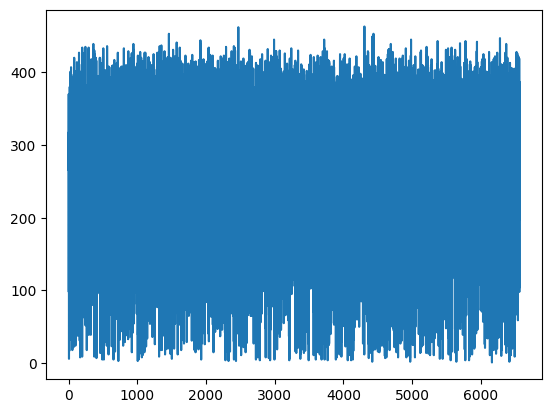

In [30]:
import matplotlib.pyplot as plt

plt.plot(word_len)